In [47]:
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [2]:
dt=pd.read_csv("data_v1.0.csv")

In [3]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6001 entries, 0 to 6000
Data columns (total 13 columns):
Unnamed: 0    6001 non-null int64
index         6001 non-null int64
date          5979 non-null object
cheveux       5973 non-null object
age           5974 non-null float64
exp           5973 non-null float64
salaire       5977 non-null float64
sexe          5978 non-null object
diplome       5965 non-null object
specialite    5974 non-null object
note          5960 non-null float64
dispo         5973 non-null object
embauche      6000 non-null float64
dtypes: float64(5), int64(2), object(6)
memory usage: 609.6+ KB


In [4]:
dt.describe()

,Unnamed: 0,index,age,exp,salaire,note,embauche
count,6001.000000,6001.000000,5974.000000,5973.000000,5977.000000,5960.000000,6000.00000
mean,3000.000000,3000.000000,35.047707,9.493387,34933.830015,75.156847,0.12250
std,1732.483814,1732.483814,9.585355,3.012115,4952.149329,17.112266,0.32789
min,0.000000,0.000000,-3.000000,0.000000,14128.000000,10.440000,0.00000
25%,1500.000000,1500.000000,29.000000,7.000000,31573.000000,63.842500,0.00000
50%,3000.000000,3000.000000,35.000000,9.000000,34969.000000,75.270000,0.00000
75%,4500.000000,4500.000000,41.000000,12.000000,38297.000000,86.472500,0.00000
max,6000.000000,6000.000000,69.000000,21.000000,53977.000000,134.140000,1.00000


In [5]:
dt=dt.drop('Unnamed: 0', axis=1)
dt=dt.drop('index', axis=1)
dt.isnull().sum()

date          22
cheveux       28
age           27
exp           28
salaire       24
sexe          23
diplome       36
specialite    27
note          41
dispo         28
embauche       1
dtype: int64

In [6]:
#drop nulls in categorical
dt=dt.dropna(subset=['cheveux', 'sexe', 'diplome', 'specialite', 'dispo', 'embauche'])
#change embauche to int
dt['embauche'] = dt['embauche'].astype(int)
#fill non categorical values
dt=dt.fillna(method='ffill')
dt.isnull().sum()

date          0
cheveux       0
age           0
exp           0
salaire       0
sexe          0
diplome       0
specialite    0
note          0
dispo         0
embauche      0
dtype: int64

In [7]:
#encode categorical data
labels = LabelEncoder()
dt['diplome_code'] = labels.fit_transform(dt['diplome'])
dt['cheveux_code'] = labels.fit_transform(dt['cheveux'])
dt['sexe_code'] = labels.fit_transform(dt['sexe'])
dt['specialite_code'] = labels.fit_transform(dt['specialite'])
dt['dispo_code'] = labels.fit_transform(dt['dispo'])

### Visualizations

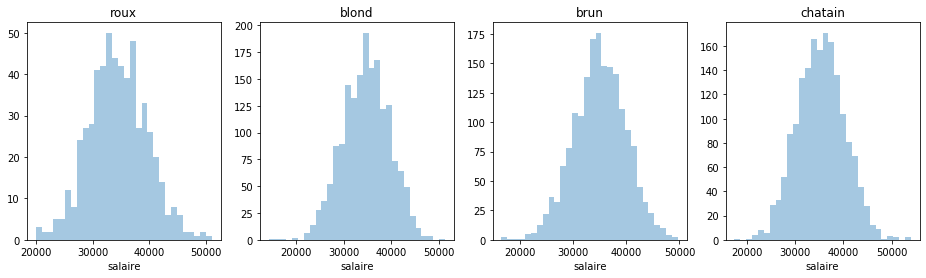

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(16, 4))
ax = sns.distplot(dt[dt['cheveux']=='roux'].salaire, bins = 30, ax = axes[0], kde = False)
ax.set_title('roux')
ax = sns.distplot(dt[dt['cheveux']=='blond'].salaire, bins = 30, ax = axes[1], kde = False)
ax.set_title('blond')
ax = sns.distplot(dt[dt['cheveux']=='brun'].salaire, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('brun')
ax = sns.distplot(dt[dt['cheveux']=='chatain'].salaire, bins = 30, ax = axes[3], kde = False)
ax = ax.set_title('chatain')

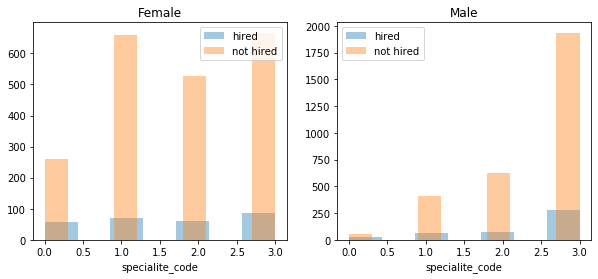

In [9]:
hired = 'hired'
not_hired = 'not hired'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = dt[dt['sexe']=='F']
men = dt[dt['sexe']=='M']
ax = sns.distplot(women[women['embauche']==1].specialite_code.dropna(), bins=7, label = hired, ax = axes[0], kde =False)
ax = sns.distplot(women[women['embauche']==0].specialite_code.dropna(), bins=10, label = not_hired, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['embauche']==1].specialite_code.dropna(), bins=7, label = hired, ax = axes[1], kde = False)
ax = sns.distplot(men[men['embauche']==0].specialite_code.dropna(), bins=10, label = not_hired, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

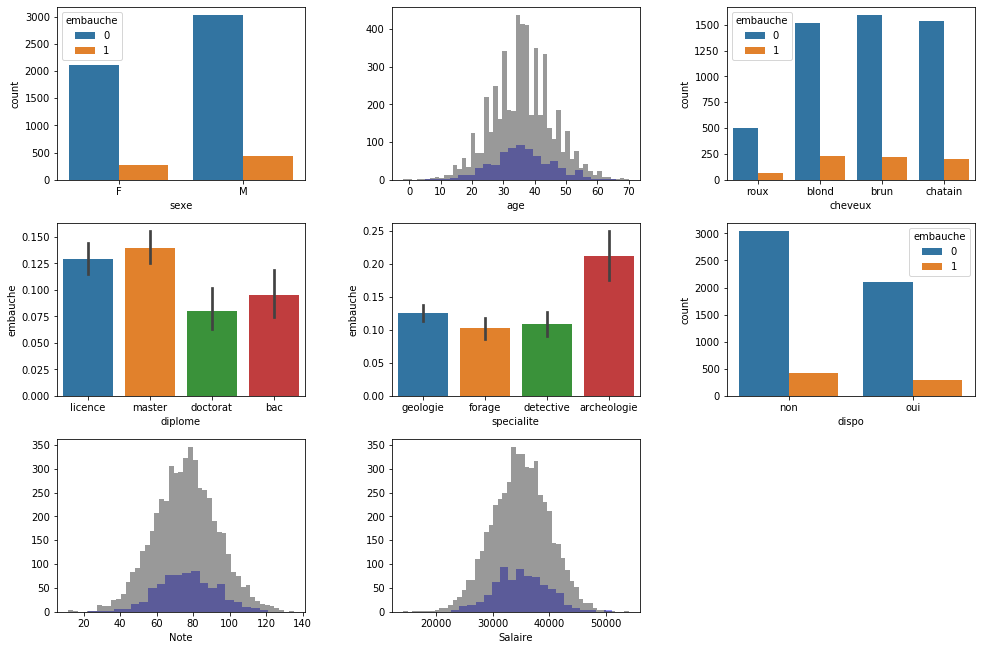

In [10]:
emb = dt[dt['embauche']==1]
noemb = dt[dt['embauche']==0]

warnings.filterwarnings(action="ignore")
plt.figure(figsize=[15,10])
plt.subplot(331)
sns.countplot('sexe',hue='embauche',data=dt)

plt.subplot(332)
sns.distplot(emb['age'].dropna().values+1, kde=False, color="blue")
sns.distplot(noemb['age'].dropna().values+1, kde=False, color="black",axlabel='age')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

plt.subplot(333)
#sns.barplot('cheveux', 'embauche', data=dt)
sns.countplot('cheveux',hue='embauche',data=dt)

plt.subplot(334)
sns.barplot('diplome', 'embauche', data=dt)

plt.subplot(335)
sns.barplot('specialite', 'embauche', data=dt)

plt.subplot(336)
#sns.barplot('dispo', 'embauche', data=dt)
sns.countplot('dispo',hue='embauche',data=dt)


plt.subplot(337)
sns.distplot(emb['note'].dropna().values+1, kde=False, color="blue")
sns.distplot(noemb['note'].dropna().values+1, kde=False, color="black",axlabel='Note')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

plt.subplot(338)
sns.distplot(emb['salaire'].dropna().values+1, kde=False, color="blue")
sns.distplot(noemb['salaire'].dropna().values+1, kde=False, color="black",axlabel='Salaire')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

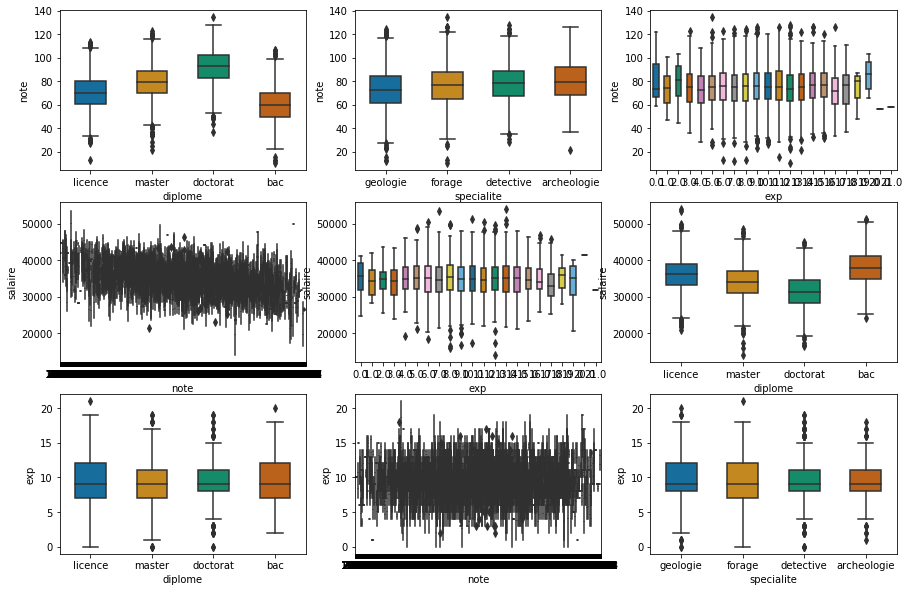

In [11]:
plt.figure(figsize=[15,10])

plt.subplot(331)
bplot = sns.boxplot(y='note', x='diplome', data=dt, width=0.5, palette="colorblind")

plt.subplot(332)
bplot = sns.boxplot(y='note', x='specialite', data=dt, width=0.5, palette="colorblind")

plt.subplot(333)
bplot = sns.boxplot(y='note', x='exp', data=dt, width=0.5, palette="colorblind")

plt.subplot(334)
bplot = sns.boxplot(y='salaire', x='note', data=dt, width=0.5, palette="colorblind")

plt.subplot(335)
bplot = sns.boxplot(y='salaire', x='exp', data=dt, width=0.5, palette="colorblind")

plt.subplot(336)
bplot = sns.boxplot(y='salaire', x='diplome', data=dt, width=0.5, palette="colorblind")

plt.subplot(337)
bplot = sns.boxplot(y='exp', x='diplome', data=dt, width=0.5, palette="colorblind")

plt.subplot(338)
bplot = sns.boxplot(y='exp', x='note', data=dt, width=0.5, palette="colorblind")

plt.subplot(339)
bplot = sns.boxplot(y='exp', x='specialite', data=dt, width=0.5, palette="colorblind")

### Parameter selection

In [12]:
X = dt
X = X.drop('embauche', axis=1)
X = X.drop('date', axis=1)
X=X.drop('cheveux', axis=1)
X=X.drop('diplome', axis=1)
X=X.drop('specialite', axis=1)
X=X.drop('dispo', axis=1)
X=X.drop('sexe', axis=1)

y = dt['embauche']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.1398255  0.10874344 0.17704227 0.24926218 0.05498049 0.08191448
 0.03789163 0.10661414 0.04372587]


In [13]:
np.argsort(-model.feature_importances_)+1

array([4, 3, 1, 2, 8, 6, 5, 9, 7], dtype=int64)

In [14]:
model.feature_importances_

array([0.1398255 , 0.10874344, 0.17704227, 0.24926218, 0.05498049,
       0.08191448, 0.03789163, 0.10661414, 0.04372587])

In [15]:
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
index_feature = model.get_support()
print(index_feature)
X_new[0]

[ True False  True  True False False False False False]


array([2.5000e+01, 2.6803e+04, 9.7080e+01])

### Statistical Significance

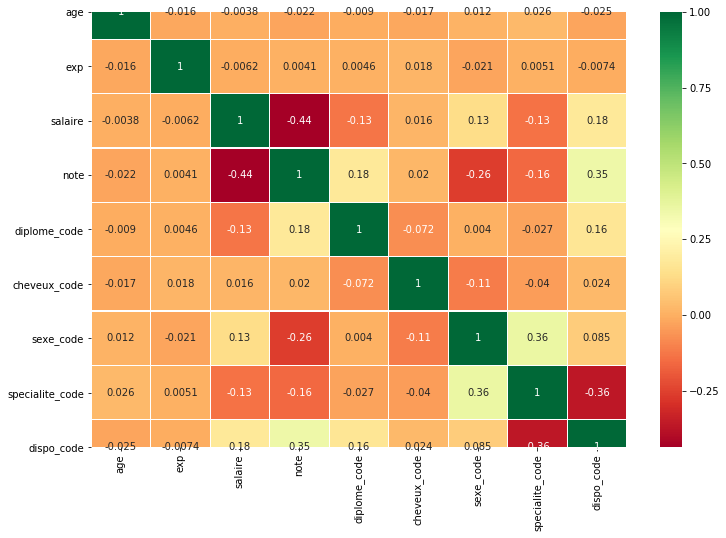

In [16]:
sns.heatmap(X.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [17]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

cont_table = pd.crosstab(dt['specialite'], dt['sexe'], rownames=['specialite'], colnames=['sexe'])
stat, p, dof, expected = chi2_contingency(cont_table)

print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

dof=3
[[ 165.19191402  239.80808598]
 [ 489.45752303  710.54247697]
 [ 523.71954964  760.28045036]
 [1212.63101331 1760.36898669]]
probability=0.950, critical=7.815, stat=746.304
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [18]:
# compare samples
stat, p = ttest_ind(X['salaire'], X['cheveux_code'])
print('Statistics=%.3f, p=%.5f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=540.164, p=0.00000
Different distributions (reject H0)


In [19]:
# compare samples
stat, p = ttest_ind(X['exp'], X['note'])
print('Statistics=%.3f, p=%.5f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=-288.856, p=0.00000
Different distributions (reject H0)


In [20]:
stat, p = f_oneway(dt['salaire'], dt['exp'], dt['note'], dt['age'])
print('Statistics=%.3f, p=%.5f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=291127.252, p=0.00000
Different distributions (reject H0)


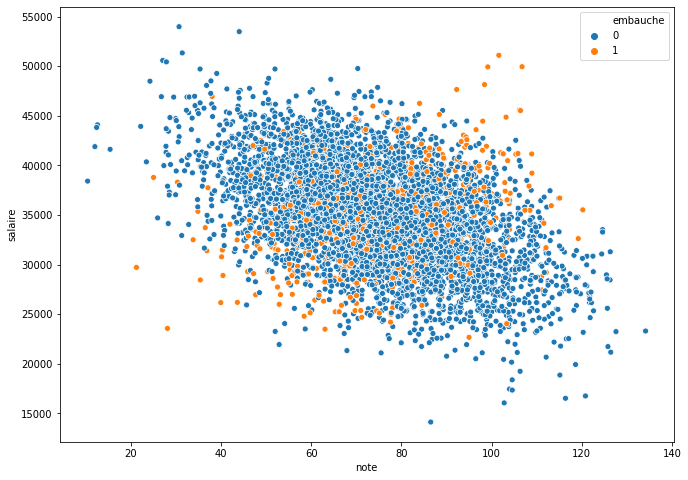

In [21]:
fig, ax = plt.subplots(figsize=(11, 8))
sns.scatterplot(x="note", y="salaire", data=X[['note','salaire']], hue=y)

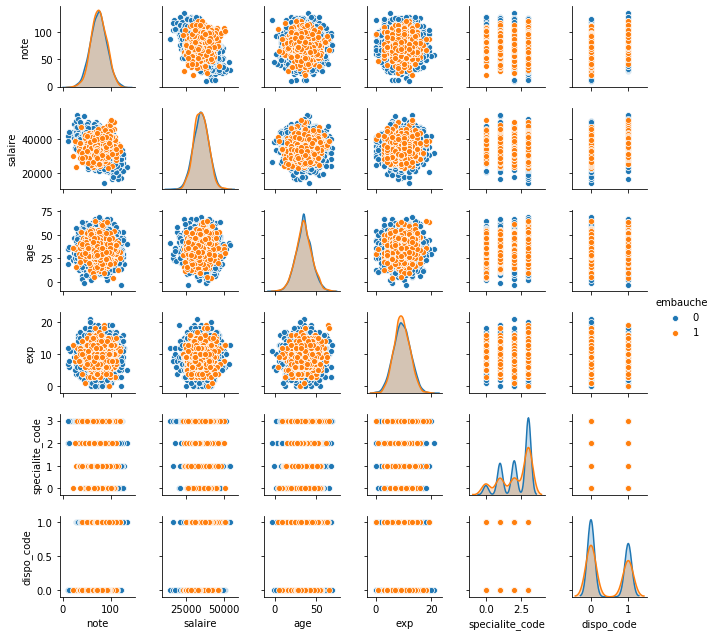

In [22]:
sns.pairplot(dt.dropna(),vars=['note','salaire','age','exp','specialite_code','dispo_code'], hue='embauche', size=1.5)

### Machine Learning analysis

In [23]:
X = dt
X = X.drop('embauche', axis=1)
X = X.drop('date', axis=1)
X=X.drop('cheveux', axis=1)
X=X.drop('diplome', axis=1)
X=X.drop('specialite', axis=1)
X=X.drop('dispo', axis=1)
X=X.drop('sexe', axis=1)

y = dt['embauche']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
confusion_matrix(y_test, y_pred)

score_log = cross_val_score(lr, X, y, cv=10)
print(score_log)

print(lr.coef_)
print(lr.intercept_)

[0.87734242 0.87734242 0.87734242 0.87713311 0.87713311 0.87713311
 0.87713311 0.87713311 0.87713311 0.87863248]
[[-6.84657359e-03 -3.11656738e-03 -3.31184803e-05 -6.61013795e-03
   1.24629666e-03 -8.91102847e-04  1.81444504e-04 -1.55820007e-03
   2.26789305e-04]]
[-0.00022316]


In [37]:
clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X,y)
score_pctr = cross_val_score(clf_pctr, X, y, cv=5).mean()
print(score_pctr)

0.424444518770705


In [38]:
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)

0.876663896352843


In [39]:
from sklearn import svm

clf_svm = svm.SVC(
    class_weight='balanced'
    )
clf_svm.fit(X, y)
score_svm = cross_val_score(clf_svm, X, y, cv=5).mean()
print(score_svm)

0.8771752595754162


In [33]:
#bayes uncorellated distributions
bay = GaussianNB()
bay.fit(X,y)
y_pred = bay.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1712
           1       0.00      0.00      0.00       223

    accuracy                           0.88      1935
   macro avg       0.44      0.50      0.47      1935
weighted avg       0.78      0.88      0.83      1935



In [35]:
#Unbalanced!
print((y_train == 1).sum())
print((y_train == 0).sum())
print((y_test == 1).sum())
print((y_test == 0).sum())

496
3431
223
1712


In [36]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(
    KNeighborsClassifier(
        n_neighbors=2,
        weights='distance'
        ),
    oob_score=True,
    max_samples=0.5,
    max_features=1.0
    )
clf_bag = bagging.fit(X,y)
score_bag = clf_bag.oob_score_
print(score_bag)

y_pred = clf_bag.predict(X_test)

print(classification_report(y_test, y_pred))

0.850733538041624
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1712
           1       0.93      0.42      0.58       223

    accuracy                           0.93      1935
   macro avg       0.93      0.71      0.77      1935
weighted avg       0.93      0.93      0.92      1935



In [42]:
clf_rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10, class_weight ="balanced_subsample")
clf_rf = clf_rf.fit(X,y)
score_rf = cross_val_score(clf_rf, X, y, cv=10)

y_pred = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(score_rf)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1712
           1       0.92      0.98      0.95       223

    accuracy                           0.99      1935
   macro avg       0.96      0.99      0.97      1935
weighted avg       0.99      0.99      0.99      1935

[0.91311755 0.91993186 0.90971039 0.90614334 0.91808874 0.92491468
 0.91979522 0.92150171 0.90784983 0.8991453 ]


In [43]:
score_rf.mean()

0.914019861007436

In [48]:
from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier( )
param_grid = { "max_depth" : [5,6],
              "subsample" : [0.5, 1],
              "learning_rate" : [0.05, 0.1, 0.15],
              "n_estimators": [50, 100, 150]}

gs = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, scoring='accuracy', cv=3)
gs = gs.fit(X,y)

y_pred = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(gs.best_score_)
print(gs.best_params_)
print(np.mean(gs.cv_results_['mean_test_score']))
print(np.mean(gs.cv_results_['std_test_score']))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1712
           1       0.92      0.98      0.95       223

    accuracy                           0.99      1935
   macro avg       0.96      0.99      0.97      1935
weighted avg       0.99      0.99      0.99      1935

0.9107813033094507
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.5}


NameError: name 'gs2' is not defined

### Clasifiers with the most important features

In [49]:
X_bal = X
y_bal = y

X_bal = X_bal.drop('diplome_code', axis=1)
X_bal = X_bal.drop('sexe_code', axis=1)
X_bal = X_bal.drop('cheveux_code', axis=1)
X_bal = X_bal.drop('dispo_code', axis=1)
X_bal = X_bal.drop('specialite_code', axis=1)

In [50]:
clf_rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10, class_weight ="balanced")
clf_rf = clf_rf.fit(X_bal,y_bal)
score_rf = cross_val_score(clf_rf, X_bal, y_bal, cv=5).mean()
print(score_rf)

0.8601144811427748


In [51]:
bay = GaussianNB(priors=None)
bay.fit(X_bal,y_bal)
score_bay = cross_val_score(bay, X_bal, y_bal, cv=10).mean()
print(score_bay)

0.8773458370684969
